In [1]:
# setup
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
np.random.seed(23)

In [2]:
# setup: has to be in a separate cell for some reason
plt.rcParams['figure.figsize'] = [10, 5]

# Individual-based models

Let's start with a simple model of the size of population of organisms.
We'll ignore sex (so, suppose these are hermaphroditic).

## Population growth

Each year, each individual will

1. maybe reproduce, and then
2. maybe die.

To make a *model* we need to decide exactly how those steps happen.
How about:

1. Each individual produces a random, Poisson number of offspring, with mean $\lambda$, and then
2. survives with probability $p$ (or else, dies).
3. Every individual does this *independently* of everyone else.


In [3]:
# poisson distribution: 20 random values from a Poisson with mean 4.5
np.random.poisson(4.5, 20)

array([6, 3, 6, 4, 0, 5, 4, 3, 6, 8, 3, 4, 6, 5, 4, 2, 6, 3, 3, 4])

Text(0.5, 1.0, 'Exponential growth')

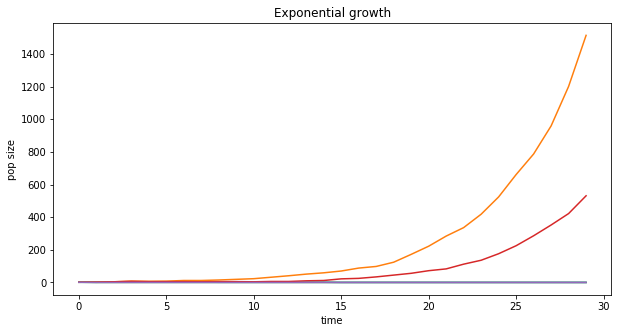

In [4]:
def exp_gen(N, lam, p):
    # N: current number of individuals
    # lam: mean number of offspring per capita
    # p: probability of survival per capita
    # should return the number of individuals in the next time step
    births = np.random.poisson(lam, N)
    survivors = (np.random.uniform(size=N) < p)
    return sum(births) + sum(survivors)

# run five simulations
N = np.full((30,5), -1, dtype='int')
N[0, :] = 1
for t in range(1, len(N)):
    for k in range(N.shape[1]):
        N[t, k] = exp_gen(N[t-1, k], 
                          lam=0.5, # mean offspring / year
                          p=0.75) # mean lifetime is 1/(1-p)

assert(np.min(N) >= 0)

fig, ax = plt.subplots()
ax.plot(N)
ax.set_xlabel("time")
ax.set_ylabel("pop size")
ax.set_title("Exponential growth")


## Population regulation

Those populations grew exponentially, if they didn't die out.
What if we want a *stable* population?
Let's say that there's "room" for around $K$ individuals, total,
and so that each new individual finds "space" to live with probability $1 - N/K$
when there's $N$ adults present.
So, 
1. Each individual produces a random, Poisson number of offspring, with mean $\lambda$, and then
2. each adult survives with probability $p$ (or else, dies), while
3. each new offspring survives with probability $1-N/K$, if there are $N$ individuals currently.
4. Every individual does this *independently* of everything else.

This is (a stochastic version of) the **logistic model** of population growth,
with fecundity/recruitment/juvenile mortality regulation.

Text(0.5, 1.0, 'Logistic growth')

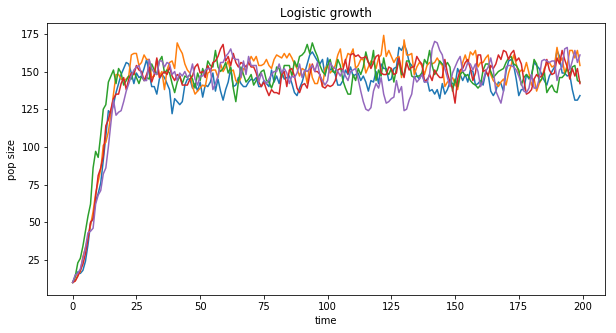

In [7]:
def logistic_generation(N, lam, p, K):
    # N: current number of individuals
    # lam: mean number of offspring per capita
    # p: probability of survival per capita
    # K: carrying capacity (total amount of spaces for individuals)
    # should return the number of individuals in the next time step
    births = np.random.poisson(lam, N)
    survivors = (np.random.uniform(size=N) < p)
    surviving_births = (np.random.uniform(size=sum(births)) < 1 - N/K)
    return sum(survivors) + sum(surviving_births)

# run five simulations
N = np.full((200, 5), -1, dtype='int')
N[0, :] = 10
for t in range(1, len(N)):
    for k in range(N.shape[1]):
        N[t, k] = logistic_generation(N[t-1, k], lam=0.4, p=0.9, K=200)


assert(np.min(N) >= 0)

fig, ax = plt.subplots()
ax.plot(N)
ax.set_xlabel("time")
ax.set_ylabel("pop size")
ax.set_title("Logistic growth")

# Exercise: explore parameter space

How do the three parameters, $\lambda$, $p$, and $K$, affect the dynamics?
For instance:
the stable population size?
the rate of growth when small?
Try to explain *what* and *why*.

# Math: it works

Now we'll see how our math-based predictions match the "reality" of our simulations.

### Speeding this up with probability

But first, let's speed up the code a bit, so we can simulate larger populations.

Above we did `sum(np.random.uniform(0, 1, N) < p)` to find the number of survivors:
all `N` individuals flip `p`-coins to decide if they live or not.
Why, that's just the Binomial($N$, $p$) distribution!
So, we could have just done `np.random.binomial(N, p, 1)`.

Also, we did `sum(np.random.poisson(lam, N)`.
But, what about **additivity of Poissons**?
If $X_1, \ldots, X_n$ are all Poisson random variables,
with means $\lambda_1, \ldots, \lambda_n$ respectively,
then $X_1 + \cdots X_n$ is *also* Poisson, with mean $\lambda_1 + \cdots + \lambda_n$.
That means we could have done `np.random.poisson(N * lam, 1)` instead.

Finally, we will be producing a Poisson number of offspring,
then each one flips a coin to decide whether to survive.
By the **Poisson thinning** property, the resulting random number is *again* Poisson distributed.
In other words, if $N$ is Poisson($\lambda$) and $M$ is Binomial($N$, $q$) given $N$,
then $M$ is Poisson($\lambda q$).

We'll also *vectorize* this, to do many simulations at once.

In [15]:
def logistic_gen(N, lam, p, K):
    # N can be a vector of current simulation states
    return (np.random.poisson(lam * N * np.fmax(0, 1 - N / K), len(N)) 
            + np.random.binomial(N, p, len(N)))

In [17]:
logistic_gen(N=np.array([10, 20, 30, 40, 50]), lam=2, p=0.5, K=20)

array([16,  8, 10, 21, 26])

### It's equation time

What we're seeing can be thought of as a combination of two things:
a deterministic trend, with randomness on top.
To describe this, we will work out the *mean* and *variance* of the population size at the next time step,
as a function of the current population size:
$$\begin{aligned}
  \mathbb{E}[N_{t+1} | N_t = n] &= F(n) \\
  \text{Var}[N_{t+1} | N_t = n] &= V(n) .
\end{aligned}$$

Suppose that the current population size is $N_t = n$.
Given this, what's the mean and variance of $N_{t+1}$?
Well, if $S$ is the number of survivors, and $T$ is the number of offspring,
then $N_{t+1} = S + T$, and
$$\begin{aligned}
  T &\sim \text{Poisson}(\lambda n (1-n/K)) \\
  S &\sim \text{Binomial}(n, p) .
\end{aligned}$$
(The distribution for $T$ follows from the *additivity* and *thinning* properties
of the Poisson distribution, above.)
These have mean and variance
$$\begin{aligned}
   \mathbb{E}[T] = \text{Var}[T] = \lambda n (1-n/K) \\
   \mathbb{E}[S] = np 
   \qquad \text{Var}[S] = np(1-p) .
\end{aligned}$$

Putting this together, we have that
$$\begin{aligned}
  F(n) &= n \left( p + \lambda \left(1 - \frac{n}{K}\right)\right) \\
       &= n + n \left( p + \lambda - 1 - \frac{\lambda n}{K}\right) \\
  V(n) &= n \left( p (1-p) + \lambda  \left(1 - \frac{n}{K}\right) \right) .
\end{aligned}$$


### The equilibrium

If $F(n_*) = n_*$, then the expected size of a population
in the next generation that starts with $n_*$ individuals is *unchanged*.
If not for randomness, a population starting with $n_*$ individuals would stay at that size forever.
To find if such a population size exists, and if so, what it is,
we solve
$$
  F(n_*) - n_* = n_* \left( p + \lambda - 1 - \frac{\lambda n_*}{K} \right) = 0 .
$$
This has two solutions, zero and $n_* = K (\lambda + p - 1)/\lambda$.
If this second solution is positive, then there's a *positive equilibrium* value.

In [18]:
def logistic_equil(lam, p, K):
    # return predicted equilibrium
    return K * (lam + p - 1) / lam

### Time to generalize

And, to save on typing, here's code to "record a bunch of simulations in the columns of an array".

In [19]:
def run_sim(N0, gen_fn, ngens, dtype='int', **kwargs):
    N = np.empty((ngens, len(N0)), dtype=dtype)
    N[0, :] = N0
    for t in range(1, ngens):
        N[t, :] = gen_fn(N[t-1, :], **kwargs)
    return N

In [29]:
## aside on using **kwargs

def f(**kwargs):
    print("kwargs is {}".format(kwargs))
    return kwargs

def g(a, b):
    print("a is {} and b is {}".format(a,b))
    return a+b

dab = f(a=1, b=2)
g(**dab)

kwargs is {'a': 1, 'b': 2}
a is 1 and b is 2


3

## Lots of simulations

Ok, **finally** let's run the simulations,
now with our theoretically predicted equilibrium size on top.

Text(0.5, 1.0, 'Logistic growth')

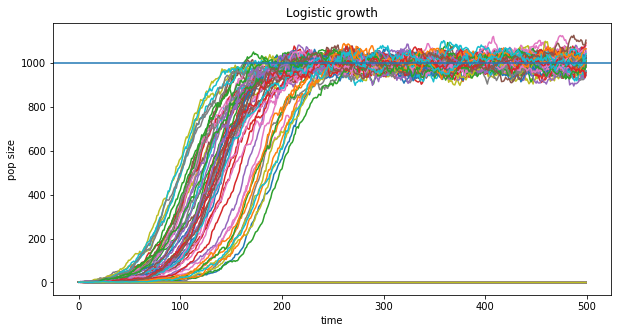

In [39]:
N = run_sim(np.repeat(1, 100), gen_fn=logistic_gen, ngens=500, 
            lam=0.1, p=0.95, K=2000)

fig, ax = plt.subplots()
ax.plot(N)
ax.axhline(y=logistic_equil(lam=0.1, p=0.95, K=2000))
ax.set_xlabel("time")
ax.set_ylabel("pop size")
ax.set_title("Logistic growth")


### Noise?


Notice above that the variance of the next time step is 
proportional to the the number of deaths plus the number of births.
This means the standard deviation is proportional to the square root of this.
Suppose that in a population of size $N$ there are $R$ births plus deaths.
This means that roughly a proportion $R/2N$ of the population is getting replaced each time step.
At the next time step, we expect the population to be of size $F(N)$ plus or minus
some "noise" of size $\sqrt{R}$. Since $R$ can't be much bigger than $N$,
$\sqrt{R}/N$, the size of the noise relative to the population, is of order $1/\sqrt{N}$.

This means that we expect the step-to-step contribution of noise
to be smaller in bigger populations.

We can see that in the plot above: the population is roughly of size $N=100$,
and the fluctuations about the average are of order 10.

# Example 1

The **Ricker model** replaces $1 - N/K$ with $\exp(-N/K)$.
How similar is it? Compare to the logistic model, with simulation and/or math:

1. the equilibrium values, and
2. the criteria for oscillations.


Text(0.5, 1.0, 'Ricker model')

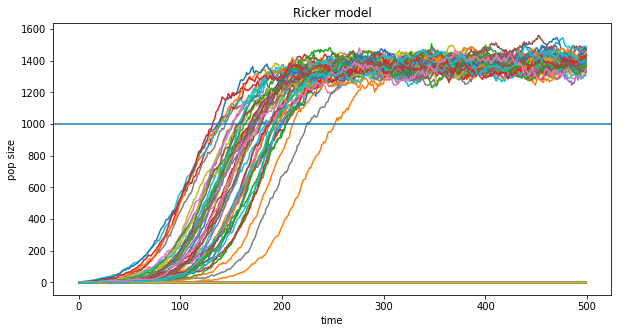

In [41]:
def ricker_gen(N, lam, p, K):
    # N can be a vector of current simulation states
    return (np.random.poisson(lam * N * np.exp(- N / K), len(N)) 
            + np.random.binomial(N, p, len(N)))

def ricker_equil(lam, p, K):
    # return predicted equilibrium
    return 

N = run_sim(np.repeat(1, 100), gen_fn=ricker_gen, ngens=500, 
            lam=0.1, p=0.95, K=2000)

fig, ax = plt.subplots()
ax.plot(N)
ax.axhline(y=logistic_equil(lam=0.1, p=0.95, K=2000))
ax.set_xlabel("time")
ax.set_ylabel("pop size")
ax.set_title("Ricker model")

# Homework 1

Simulate and plot *allele frequencies* in the logistic model:
modify the model to keep track of not only numbers of individuals,
but how many carry each of two alleles at a biallelic locus.
(Still, don't worry about sex - keep assuming uniparental reproduction of haploid individuals.)
Then, plot:

1. Trajectories of $p(t)$, the allele frequency, and $N(t)$, the population size, against time,
   for a reasonable amount of time.

2. A plot of allele frequency change against allele frequncy, i.e.,
    plot $\Delta p(t) = p(t+1) - p(t)$ against $p(t)$.
    Compare the noise in this plot to the value from theory:
    the SD of $\Delta p(t)$ is $\sqrt{p(t) (1-p(t))/N(t)}$.


# Logistic cobwebs

Now let's look more at the function $n \mapsto F(n)$.
We can do this the "math-free" way by just plotting the population size
after one time step of the simulation
starting from a grid of possible initial sizes.
The diagonal red line is where $F(n) = n$, i.e.: equilibrium!

In [ ]:
X = np.fromiter(range(200), dtype='int')
Y = logistic_gen(X, lam=0.5, p=0.95, K=200)
plt.plot(X, Y)
plt.plot([0.0, 200], [0.0, 200])
plt.xlabel("N(t)")
plt.ylabel("N(t+1)")
plt.show()

That's hard to see! Let's look at $n \mapsto (F(n) - n)$ instead.
The horizontal line is where $F(n) - n = 0$, again: equilibrium!

In [ ]:
plt.plot(X, Y-X)
plt.axhline(0.0)
plt.axvline(x=logistic_equil(lam=0.5, p=0.95, K=200), color='r')
plt.xlabel("N(t)")
plt.ylabel("N(t+1) - N(t)")
plt.show()

### New parameters

Now let's spice things up by changing the parameters to
$$\begin{aligned}
 \lambda &= 5 \\
 p &= 0.25 \\
 K &= 200
\end{aligned}$$

In [ ]:
N = run_sim(np.repeat(170, 20), gen_fn=logistic_gen, ngens=10,
            lam=5.0, p=0.25, K=200)
equil = logistic_equil(lam=5.0, p=0.25, K=200)
    
plt.plot(N, label='logistic growth')
plt.axhline(y=equil)
plt.xlabel("time")
plt.ylabel("pop size")
plt.show()

Wow, what happened? The population is **oscillating**.
Let's look at $F(n)$ to understand.

In [ ]:
X = np.fromiter(range(300), dtype='int')
Y = logistic_gen(X, lam=5., p=0.25, K=200)

fig, ax = plt.subplots()
ax.plot(X, Y)
ax.plot([0.0, 300], [0.0, 300])
ax.axhline(y=equil, color='m', linestyle="dotted")
ax.axvline(x=equil, color='m', linestyle="dotted")
ax.set_xlabel("N(t)")
ax.set_ylabel("N(t+1)")
plt.show()

**Question:** What's that wierd tail?

### The cobweb plot

Using a plot of the *expected value* curve $f(n) = \mathbb{E}[N_{t+1} | N_t = n]$,
you can trace the expected dynamics
as
$$
 n \mapsto f(n) \mapsto f(f(n)) \mapsto f(f(f(n))) \mapsto \cdots
$$
by "bouncing off the diagonal".

It's easier to explain with a picture.

In [ ]:
def cobweb_plot(N, ax):
    for k in range(N.shape[1]):
        X = np.repeat(N[:, k], 2)[:-1]
        Y = np.repeat(N[:, k], 2)[1:]
        ax.plot(X, Y)

# NOTE: run this again to get more cobwebs!
N = run_sim(np.array([200]), gen_fn=logistic_gen, ngens=10,
            lam=5.0, p=0.25, K=200)     
print("Population size:", N.T)

cobweb_plot(N[:, :1], ax)
fig

# Exercise: dizzy spiders

**Fact:** If the *slope* of $F()$ (the blue curve above)
at the *equilibrium* (the magenta dotted lines) is steeper than $-1$,
then the equilibrium is *unstable*
(and so the population will tend to oscillate around it).

Experiment to convince yourself of this,
draw pictures on the whiteboard with your neighbor,
then explain why this happens.

# The differential equation version

**The logistic model** of population growth is often defined as the differential equation
$$
 \frac{d}{dt} n(t) = r n(t) \left(1 - \frac{n(t)}{C}\right) .
$$
These are *deterministic*, and also *continuous time*.

What's the relationship?
To get there, we need to reparameterize so that
each time step is *very short*.
Let's say that one old time step is equivalent to $T$ new ones.

**Death:** Before, in a population of size $N$ we'd get about $(1-p)N$ deaths per time step;
so now these should be spread out over $T$ steps.
Setting the probability of death to $\mu/T$ would accomplish this
(so, $p = 1 - \mu/T$).

**Reproduction:** And, each individual produced a Poisson($\lambda$) number of offspring per time step.
If they don't die, this is equivalent to producing a Poisson($\lambda/T$) number of offspring
in each of $T$ time steps, so we should change $\lambda \mapsto \lambda / T$.

This gets us the deterministic recursion
$$\begin{aligned}
  n_{t+1/T} - n_t
  &=
  (p + \lambda - 1) n_t \left( 1 - \frac{n_t}{(p + \lambda - 1) K / \lambda}\right) \\
  &=
  \frac{1}{T} \mu n_t \left( 1 - \frac{n_t}{\mu K / \lambda}\right) .
\end{aligned}$$

## Rescaling

This leads to the **question:**
What happens to our model if we
1. set one time step to be $1/T$ units of time,
2. reduce the probability of death and mean fecundity by a factor of $T$ per time step, as above,
3. and take $T \to \infty$?

**We'll do this on the board.**

## What about noise?

Above we saw that bigger populations
had less noise (in this model anyhow).
This says that **bigger populations** should behave more like
solutions to the **differential equation**.
Let's see how that holds up in our simulations.

In [ ]:
for K in [200, 2000, 20000]:
    print(K)
    N = run_sim(np.array([0.6, 0.8, 1.0, 1.2, 1.4]) * logistic_equil(lam=0.1, p=0.95, K=K), 
                gen_fn=logistic_gen, ngens=120, 
                lam=0.1, p=0.95, K=K)
    plt.plot(N)
    plt.axhline(y=logistic_equil(lam=0.1, p=0.95, K=K))
    plt.xlabel("time")
    plt.ylabel("pop size")
    plt.title("K={}".format(K))
    plt.show()

# Oscillations, and Chaos

It would be a crime to talk about the logistic equation
and not see period doubling, and chaos.
A nice review of complicated behavior in simple models is [May 1976](http://abel.harvard.edu/archive/118r_spring_05/docs/may.pdf).
In this section we'll just work with the determinstic model
(remember that $r = \lambda + p -1$
and we'll switch out $K$ for $n_* = K r / \lambda$, to be consistent with the literature).

In [ ]:
def logistic_step(N, r, C):
    return N + r * N * (1 - N / C)

To see if the model approaches a stable, *oscillating* equilibrium,
we can (a) iterate the model for a while,
and then see if the values repeat.
For instance, at $r=2.1$ there's a period-2 loop:

In [ ]:
N = run_sim([60], gen_fn=logistic_step, dtype='float',
            ngens=50, r=2.1, C=100)

plt.plot(range(N.shape[0]), N, linestyle="dotted")
plt.scatter(range(N.shape[0]), N)
plt.xlabel("time")
plt.ylabel("pop size")
plt.show()

Here's another example (at $r=2.5$, with period 4):

In [ ]:
N = run_sim([10], gen_fn=logistic_step, dtype='float',
            ngens=100, r=2.5, C=100)

plt.plot(range(N.shape[0]), N, linestyle="dotted")
plt.scatter(range(N.shape[0]), N)
plt.xlabel("time")
plt.ylabel("pop size")
plt.show()

... and, what's going on here???

In [ ]:
N = run_sim([10], gen_fn=logistic_step, dtype='float',
            ngens=100, r=2.9, C=100)

plt.plot(range(N.shape[0]), N, linestyle="dotted")
plt.scatter(range(N.shape[0]), N)
plt.xlabel("time")
plt.ylabel("pop size")
plt.show()

Ok, now let's see how that behaves as we change $r$.
To save space, we'll (a) cut out the first bunch of steps of each simulation,
and (b) plot the values of $N_t$ against their respective values of $r$
(so the first plot above would be compressed to just two points, at about 82 and 111, above $r=2.1$.

In [ ]:
rvals = np.linspace(1.5, 3.0, num=400)
N = run_sim(np.repeat(10.0, len(rvals)), gen_fn=logistic_step,
            dtype='float', ngens=200, r=rvals, C=100)

plot_gens = 20
plt.scatter(np.row_stack([rvals]*plot_gens), N[-plot_gens:,:],
            marker='.')
plt.show()

The first "period doubling", where the single stable cycle becomes unstable,
occurs at $r=\sqrt{6}$.
The period doubles again, followed soon by the onset of chaos.

# Homework 2

Here is another "logistic" model.
Suppose that everyone dies ever time step,
and that large populations deplete the amount of resources left for the next generation.
The net effect is that the mean fecundity of an individual
in a population of size $N$ is $1 + r - N/\beta$,
so that $1+r$ is the mean fecundity in the presence of lots of resources,
but that mean fecundity decreases by $\beta$ for each additional neighbor.
Implement a simulation of this process (using Poisson offspring and Poisson additivity),
and find it's equilibrium in terms of $r$ and $\beta$.

*Bonus:* We can't see chaos in our simulations above because of the `max(0.0, 1-N/K)` term.
We *can* see it in this model. Find parameter values with (a) a bistable cycle and (b) chaos.